In [1]:
'''
序列恢复率
'''

def calculate_recovery(seq_ref, seq_designed):
    assert len(seq_ref) == len(seq_designed), "Sequences must be of the same length"
    
    n = len(seq_ref)
    recovery_count = sum(1 for x, y in zip(seq_ref, seq_designed) if x == y)
    recovery_rate = recovery_count / n
    return recovery_rate

# 示例使用
seq_ref = "ACDEFGHIKLMNPQRSTVWY"
seq_designed = "ACDIFGHIKLMNPQRSTVWY"
recovery = calculate_recovery(seq_ref, seq_designed)
print(f"Recovery Rate: {recovery:.2%}")


Recovery Rate: 95.00%


In [2]:
import subprocess
'''
计算多肽的sc-TM (自洽TM分数),“sc-TM”指标用来评估设计蛋白质结构的质量
'''
def run_tm_align(pdb_file1, pdb_file2):
    # 运行 TM-align
    result = subprocess.run(['/root/autodl-tmp/PP_generate_v1/data/downloads/TMalign', pdb_file1, pdb_file2], capture_output=True, text=True)
    # 解析输出，抽取 TM 分数
    for line in result.stdout.split('\n'):
        if "TM-score" in line and "Chain_1" in line:
            tm_score = float(line.split()[1])
            return tm_score

# 示例文件路径
pdb_file1 = "/root/autodl-tmp/PP_generate_v1/data/PPDbench/1cjr/peptide.pdb"
pdb_file2 = "/root/autodl-tmp/PP_generate_v1/data/downloads/result/1cjr_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb"

# 计算并打印 TM 分数
tm_score = run_tm_align(pdb_file1, pdb_file2)
print(f"sc-TM Score: {tm_score}")


sc-TM Score: None


Processing IDs: 100%|██████████| 133/133 [00:00<00:00, 141.97it/s]
/tmp/ipykernel_4338/2012237389.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


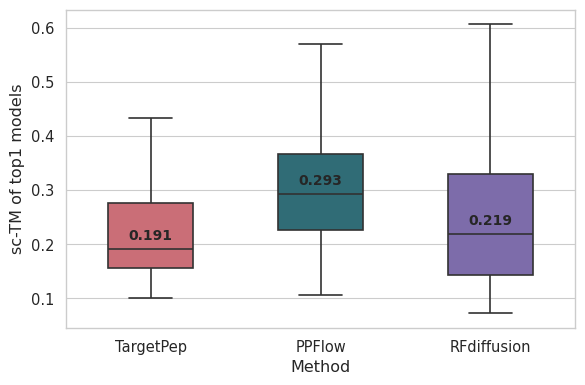

箱线图已保存: /root/autodl-tmp/PP_generate_v1/data/Diversity/scTM_top1_boxplot.png


In [12]:
'''计算多肽与天然肽的sc-TM  (top1)'''
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os, re, json, subprocess
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 0️⃣  路径模板
# -------------------------------------------------------------
JSON_ID     = "/root/autodl-tmp/PP_generate_v1/data/SOTA/peptides_sota.json"
TMALIGN_EXE = "/root/autodl-tmp/PP_generate_v1/data/downloads/TMalign"
OUT_PLOT    = "/root/autodl-tmp/PP_generate_v1/data/Diversity/scTM_top1_boxplot.png"

NATIVE_TMPL = "/root/autodl-tmp/PP_generate_v1/data/PPDbench/{id}/peptide.pdb"

def gen_paths(pid):      # TargetPep / Generated
    return [f"/root/autodl-tmp/peptides1/{pid}.pdb"]

def ppflow_paths(pid):
    return [f"/root/autodl-tmp/ppflow/{pid}/0001.pdb"]

def rfdiff_paths(pid):
    return [f"/root/autodl-tmp/RFdiffusion_top7/{pid}_2.pdb"]
# def gen_paths(pid):      # TargetPep / Generated
#     return [f"/root/autodl-tmp/peptides{i}/{pid}.pdb" for i in range(1, 6)]

# def ppflow_paths(pid):
#     return [f"/root/autodl-tmp/ppflow{i}/{pid}/0001.pdb" for i in range(1, 6)]

# def rfdiff_paths(pid):
#     return [f"/root/autodl-tmp/RFdiffusion_top5/{pid}_{i}.pdb" for i in range(1, 6)]

PATH_FUNCS = {
    "TargetPep":   gen_paths,
    "PPFlow":      ppflow_paths,
    "RFdiffusion": rfdiff_paths,
}

# -------------------------------------------------------------
# 1️⃣  调 TM-align 抓 sc-TM 分数
# -------------------------------------------------------------
TM_RE = re.compile(r"TM-score\s*=\s*([0-9.]+)")

def sc_tm(nat_pdb, mod_pdb):
    if not os.path.isfile(mod_pdb):
        return None
    cmd = [TMALIGN_EXE, mod_pdb, nat_pdb]
    try:
        res = subprocess.run(cmd, capture_output=True, text=True, check=True)
    except subprocess.CalledProcessError:
        return None
    for ln in res.stdout.splitlines():
        m = TM_RE.search(ln)
        if m:
            return float(m.group(1))
    return None

# -------------------------------------------------------------
# 2️⃣  遍历所有 ID
# -------------------------------------------------------------
with open(JSON_ID) as f:
    ids = list(json.load(f).keys())

records = []
for pid in tqdm(ids, desc="Processing IDs"):
    nat_pdb = NATIVE_TMPL.format(id=pid)
    if not os.path.isfile(nat_pdb):
        continue

    for method, fn in PATH_FUNCS.items():
        vals = [sc_tm(nat_pdb, p) for p in fn(pid)]
        vals = [v for v in vals if v is not None]
        if vals:                              # 至少成功一次
            records.append({
                "id": pid,
                "method": method,
                "sc_tm": float(np.mean(vals))   # 5 个模型的均值
            })

df = pd.DataFrame(records)
if df.empty:
    raise RuntimeError("没有任何 sc-TM 数据，请检查文件路径或 TM-align 输出")

# -------------------------------------------------------------
# 3️⃣  绘制箱线图 + 中位数
# -------------------------------------------------------------
order   = ["TargetPep", "PPFlow", "RFdiffusion"]
palette = ['#d95f6b', '#247482', '#7962b4']

sns.set(style="whitegrid", context="paper", font_scale=1.2)
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=df, x="method", y="sc_tm",
    order=order, palette=palette,
    ax=ax, width=.5, linewidth=1.2, showfliers=False
)

# —— 标中位数 ——
med = df.groupby("method")["sc_tm"].median()
ymin, ymax = ax.get_ylim(); shift = (ymax - ymin) * 0.02
for i, m in enumerate(order):
    ax.text(i, med[m] + shift, f"{med[m]:.3f}",
            ha="center", va="bottom", fontsize=10, fontweight="bold")

ax.set_xlabel("Method")
# ax.set_ylabel("mean sc-TM of 5 models")
ax.set_ylabel("sc-TM of top1 models")
fig.tight_layout()

Path(OUT_PLOT).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(OUT_PLOT, dpi=300)
plt.show()
print("箱线图已保存:", OUT_PLOT)


Processing IDs:   0%|          | 0/133 [00:00<?, ?it/s]

Processing IDs: 100%|██████████| 133/133 [00:02<00:00, 58.42it/s]
/tmp/ipykernel_4338/2703428075.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


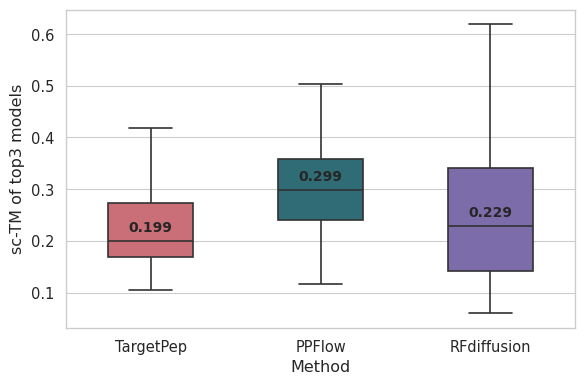

箱线图已保存: /root/autodl-tmp/PP_generate_v1/data/Diversity/scTM_top3_boxplot.png


In [11]:
'''计算多肽与天然肽的sc-TM  (top3)'''
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os, re, json, subprocess
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 0️⃣  路径模板
# -------------------------------------------------------------
JSON_ID     = "/root/autodl-tmp/PP_generate_v1/data/SOTA/peptides_sota.json"
TMALIGN_EXE = "/root/autodl-tmp/PP_generate_v1/data/downloads/TMalign"
OUT_PLOT    = "/root/autodl-tmp/PP_generate_v1/data/Diversity/scTM_top3_boxplot.png"

NATIVE_TMPL = "/root/autodl-tmp/PP_generate_v1/data/PPDbench/{id}/peptide.pdb"

def gen_paths(pid):      # TargetPep / Generated
    return [f"/root/autodl-tmp/peptides{i}/{pid}.pdb" for i in range(1, 4)]

def ppflow_paths(pid):
    return [f"/root/autodl-tmp/ppflow/{pid}/000{i}.pdb" for i in range(1, 4)]

def rfdiff_paths(pid):
    return [f"/root/autodl-tmp/RFdiffusion_top7/{pid}_{i}.pdb" for i in range(1,3,6)]

PATH_FUNCS = {
    "TargetPep":   gen_paths,
    "PPFlow":      ppflow_paths,
    "RFdiffusion": rfdiff_paths,
}

# -------------------------------------------------------------
# 1️⃣  调 TM-align 抓 sc-TM 分数
# -------------------------------------------------------------
TM_RE = re.compile(r"TM-score\s*=\s*([0-9.]+)")

def sc_tm(nat_pdb, mod_pdb):
    if not os.path.isfile(mod_pdb):
        return None
    cmd = [TMALIGN_EXE, mod_pdb, nat_pdb]
    try:
        res = subprocess.run(cmd, capture_output=True, text=True, check=True)
    except subprocess.CalledProcessError:
        return None
    for ln in res.stdout.splitlines():
        m = TM_RE.search(ln)
        if m:
            return float(m.group(1))
    return None

# -------------------------------------------------------------
# 2️⃣  遍历所有 ID
# -------------------------------------------------------------
with open(JSON_ID) as f:
    ids = list(json.load(f).keys())

records = []
for pid in tqdm(ids, desc="Processing IDs"):
    nat_pdb = NATIVE_TMPL.format(id=pid)
    if not os.path.isfile(nat_pdb):
        continue

    for method, fn in PATH_FUNCS.items():
        vals = [sc_tm(nat_pdb, p) for p in fn(pid)]
        vals = [v for v in vals if v is not None]
        if vals:                              # 至少成功一次
            records.append({
                "id": pid,
                "method": method,
                "sc_tm": float(np.mean(vals))   # 5 个模型的均值
            })

df = pd.DataFrame(records)
if df.empty:
    raise RuntimeError("没有任何 sc-TM 数据，请检查文件路径或 TM-align 输出")

# -------------------------------------------------------------
# 3️⃣  绘制箱线图 + 中位数
# -------------------------------------------------------------
order   = ["TargetPep", "PPFlow", "RFdiffusion"]
palette = ['#d95f6b', '#247482', '#7962b4']

sns.set(style="whitegrid", context="paper", font_scale=1.2)
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=df, x="method", y="sc_tm",
    order=order, palette=palette,
    ax=ax, width=.5, linewidth=1.2, showfliers=False
)

# —— 标中位数 ——
med = df.groupby("method")["sc_tm"].median()
ymin, ymax = ax.get_ylim(); shift = (ymax - ymin) * 0.02
for i, m in enumerate(order):
    ax.text(i, med[m] + shift, f"{med[m]:.3f}",
            ha="center", va="bottom", fontsize=10, fontweight="bold")

ax.set_xlabel("Method")
ax.set_ylabel("sc-TM of top3 models")
fig.tight_layout()

Path(OUT_PLOT).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(OUT_PLOT, dpi=300)
plt.show()
print("箱线图已保存:", OUT_PLOT)


Processing IDs: 100%|██████████| 133/133 [00:04<00:00, 26.98it/s]
/tmp/ipykernel_4338/2450150.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


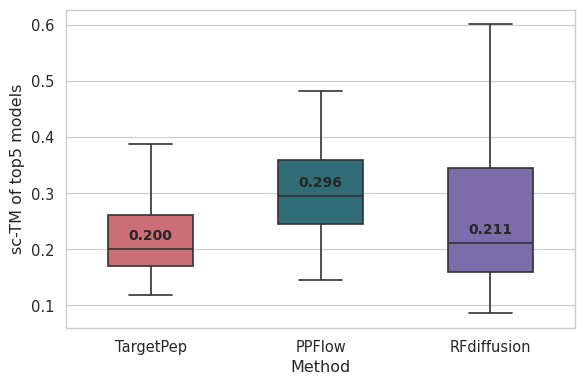

箱线图已保存: /root/autodl-tmp/PP_generate_v1/data/Diversity/scTM_top5_boxplot.png


In [10]:
'''计算多肽与天然肽的sc-TM  (top5)'''
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os, re, json, subprocess
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 0️⃣  路径模板
# -------------------------------------------------------------
JSON_ID     = "/root/autodl-tmp/PP_generate_v1/data/SOTA/peptides_sota.json"
TMALIGN_EXE = "/root/autodl-tmp/PP_generate_v1/data/downloads/TMalign"
OUT_PLOT    = "/root/autodl-tmp/PP_generate_v1/data/Diversity/scTM_top5_boxplot.png"

NATIVE_TMPL = "/root/autodl-tmp/PP_generate_v1/data/PPDbench/{id}/peptide.pdb"

def gen_paths(pid):      # TargetPep / Generated
    return [f"/root/autodl-tmp/peptides{i}/{pid}.pdb" for i in range(1, 6)]

def ppflow_paths(pid):
    return [f"/root/autodl-tmp/ppflow/{pid}/000{i}.pdb" for i in range(1, 6)]

def rfdiff_paths(pid):
    return [f"/root/autodl-tmp/RFdiffusion_top7/{pid}_{i}.pdb" for i in range(1, 6)]

PATH_FUNCS = {
    "TargetPep":   gen_paths,
    "PPFlow":      ppflow_paths,
    "RFdiffusion": rfdiff_paths,
}

# -------------------------------------------------------------
# 1️⃣  调 TM-align 抓 sc-TM 分数
# -------------------------------------------------------------
TM_RE = re.compile(r"TM-score\s*=\s*([0-9.]+)")

def sc_tm(nat_pdb, mod_pdb):
    if not os.path.isfile(mod_pdb):
        return None
    cmd = [TMALIGN_EXE, mod_pdb, nat_pdb]
    try:
        res = subprocess.run(cmd, capture_output=True, text=True, check=True)
    except subprocess.CalledProcessError:
        return None
    for ln in res.stdout.splitlines():
        m = TM_RE.search(ln)
        if m:
            return float(m.group(1))
    return None

# -------------------------------------------------------------
# 2️⃣  遍历所有 ID
# -------------------------------------------------------------
with open(JSON_ID) as f:
    ids = list(json.load(f).keys())

records = []
for pid in tqdm(ids, desc="Processing IDs"):
    nat_pdb = NATIVE_TMPL.format(id=pid)
    if not os.path.isfile(nat_pdb):
        continue

    for method, fn in PATH_FUNCS.items():
        vals = [sc_tm(nat_pdb, p) for p in fn(pid)]
        vals = [v for v in vals if v is not None]
        if vals:                              # 至少成功一次
            records.append({
                "id": pid,
                "method": method,
                "sc_tm": float(np.mean(vals))   # 5 个模型的均值
            })

df = pd.DataFrame(records)
if df.empty:
    raise RuntimeError("没有任何 sc-TM 数据，请检查文件路径或 TM-align 输出")

# -------------------------------------------------------------
# 3️⃣  绘制箱线图 + 中位数
# -------------------------------------------------------------
order   = ["TargetPep", "PPFlow", "RFdiffusion"]
palette = ['#d95f6b', '#247482', '#7962b4']

sns.set(style="whitegrid", context="paper", font_scale=1.2)
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=df, x="method", y="sc_tm",
    order=order, palette=palette,
    ax=ax, width=.5, linewidth=1.2, showfliers=False
)

# —— 标中位数 ——
med = df.groupby("method")["sc_tm"].median()
ymin, ymax = ax.get_ylim(); shift = (ymax - ymin) * 0.02
for i, m in enumerate(order):
    ax.text(i, med[m] + shift, f"{med[m]:.3f}",
            ha="center", va="bottom", fontsize=10, fontweight="bold")

ax.set_xlabel("Method")
ax.set_ylabel("sc-TM of top5 models")
fig.tight_layout()

Path(OUT_PLOT).parent.mkdir(parents=True, exist_ok=True)
fig.savefig(OUT_PLOT, dpi=300)
plt.show()
print("箱线图已保存:", OUT_PLOT)
